In [ ]:
from google.colab import files

uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!pip install kaggle

In [ ]:
!kaggle competitions download -c ultra-wide-band-pose-prediction

100% 986M/987M [00:47<00:00, 20.1MB/s]
100% 987M/987M [00:47<00:00, 21.8MB/s]


In [ ]:
!unzip ultra-wide-band-pose-prediction.zip

Archive:  ultra-wide-band-pose-prediction.zip
  inflating: annotations.csv         
  inflating: classes.csv             
  inflating: sample_submission.csv   
  inflating: test/test/0235320b-1bad-4422-98d5-5c14cf9ddd59.npy  
  inflating: test/test/04079ed6-01e6-42bc-b8a0-b30ea9446bf5.npy  
  inflating: test/test/052d35a0-25d8-4eea-9827-2f8d18b6aa99.npy  
  inflating: test/test/0613da04-d5f9-4989-b1be-4ce1f3c06dc4.npy  
  inflating: test/test/07159490-a60b-4512-9538-4357d145f5ff.npy  
  inflating: test/test/09726b64-488b-48dc-b44a-87a0c3a8f6a3.npy  
  inflating: test/test/0b546103-eb69-4778-8ce7-38c1f69c9217.npy  
  inflating: test/test/0bf17f5b-f52c-42ef-b771-0187588ad2de.npy  
  inflating: test/test/0d097254-9d9a-4348-bcda-73b534ff27c9.npy  
  inflating: test/test/11cd15be-5674-4b46-900b-1a38dda972c6.npy  
  inflating: test/test/158922c9-ac47-415e-94c2-d9adcfbe509c.npy  
  inflating: test/test/1589af85-8afe-43c3-a928-4c44b52164ff.npy  
  inflating: test/test/15e8312f-b7b8-4291-8258-1

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

annotations = pd.read_csv("/content/annotations.csv")
annotations

,id,class
0,80a8dc1d-b216-469c-91b1-fc257562a883,0
1,3ab012da-927a-40d6-95f8-5a2f96dad360,0
2,eef92f84-5127-4063-a4a2-fee4035b1ac7,0
3,8d562739-6502-4a6c-8b83-e029b795f685,0
4,404c2e92-1101-4e62-83bf-a6fdb7dfcb9a,0
...,...,...
642,ea5513a7-f18a-4393-8ab4-44e574e70f2b,4
643,edf4aec3-410d-4ed3-90d2-12671bb4c625,4
644,297e1f02-66ac-4e4e-849a-da2f1103e8a0,4
645,926418bb-2e66-4c82-82b1-13a82faf73b4,4


In [ ]:
annotations.shape

(647, 2)

In [ ]:
data = []
labels = []

for index in range(annotations.shape[0]):
    file_path = '/content/train/train/{0}.npy'.format(annotations['id'][index])
    np_data = np.load(file_path)
    data.append(np_data)
    labels.append(annotations['class'][index])

len(data), len(data[0])

(647, 2560)

In [ ]:
import scipy.fftpack as fft

def Range_frequency(datas):
    Range_frequency_frame = []
    for data in datas:
        dB = True
        # Range-Doppler
        rd = fft.fft(data, axis=0)
        rd = fft.fftshift(rd, axes=0)
        rd = abs(rd)
        DBrd = 20 * np.log10(rd+1e-10)
        Range_frequency_frame.append(DBrd)
    return np.stack(Range_frequency_frame)

def range_time(IQ_data):
    n_rd_history = 256
    frame = []
    frames = []
    for iqini in IQ_data:
        if len(frame)<n_rd_history:
            frame.append(iqini)
        else:
            frames.append(np.copy(frame))
            frame.append(iqini)
            frame = frame[1::]
    return np.stack(frames)

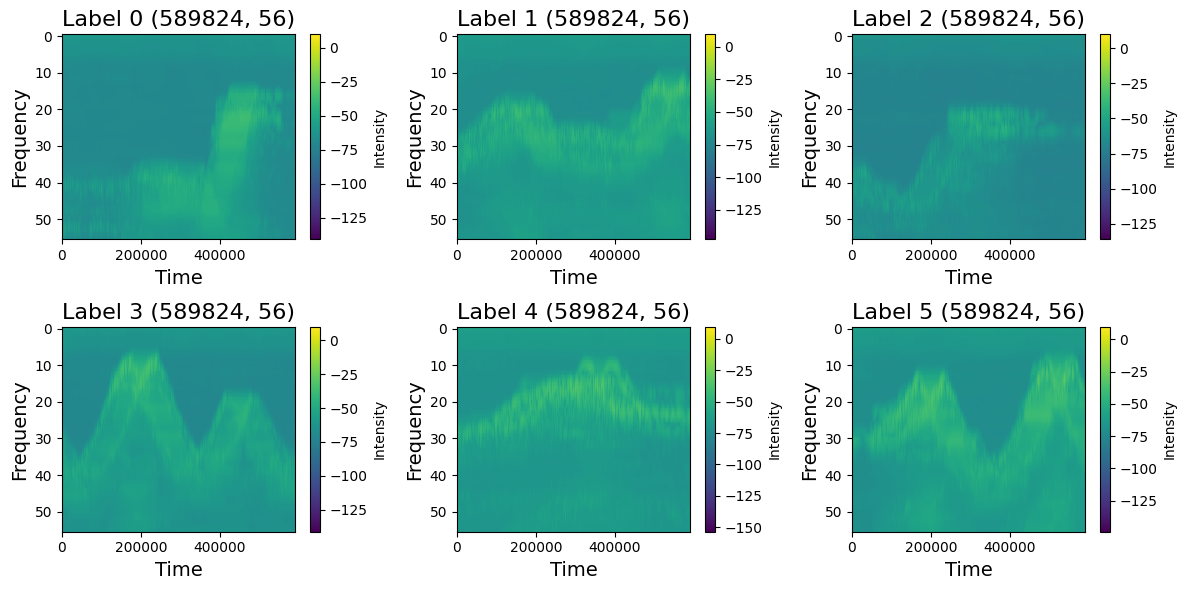

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, label in enumerate([0, 1, 2, 3, 4, 5]):
    img = range_time(data[labels.index(label)])
    row = i // 3
    col = i % 3
    img = Range_frequency(img)
    img = img.reshape(img.shape[0] * img.shape[1], img.shape[2])
    axes[row, col].set_title(f"Label {label} {img.shape}", fontsize=16)
    axes[row, col].set_xlabel("Time", fontsize=14)
    axes[row, col].set_ylabel("Frequency", fontsize=14)
    im = axes[row, col].imshow(img.T, aspect="auto", cmap='viridis')
    fig.colorbar(im, ax=axes[row, col], label='Intensity')

plt.tight_layout()
plt.show()

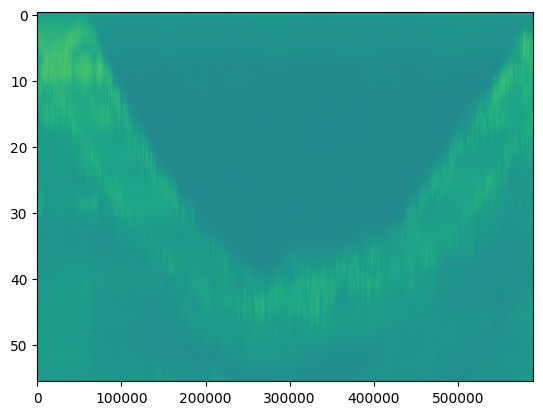

In [ ]:
img = range_time(data[labels.index(6)])
img = Range_frequency(img)
img = img.reshape(img.shape[0] * img.shape[1], img.shape[2])
plt.imshow(img.T, aspect="auto")

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.1, random_state=42, stratify=labels)
len(X_train), len(X_val)

(582, 65)

In [ ]:
output_folder = '/content/drive/MyDrive/Colab Notebooks/data/signal_train/'
os.makedirs(output_folder, exist_ok=True)

for i in tqdm(range(len(X_train))):
    train = X_train[i]
    train = range_time(train)
    train = Range_frequency(train)
    train = train.reshape(train.shape[0] * train.shape[1], train.shape[2])
    label = y_train[i]
    label_folder = os.path.join(output_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)
    file_path = os.path.join(label_folder, str(i) + '.png')
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(np.abs(train.T), aspect="auto")
    fig.savefig(file_path)
    fig.clear()
    plt.close(fig)

100%|██████████| 582/582 [53:12<00:00,  5.48s/it]


In [ ]:
output_folder = '/content/drive/MyDrive/Colab Notebooks/data/signal_val/'
os.makedirs(output_folder, exist_ok=True)

for i in tqdm(range(len(X_val))):
    train = X_val[i]
    train = range_time(train)
    train = Range_frequency(train)
    train = train.reshape(train.shape[0] * train.shape[1], train.shape[2])
    label = y_val[i]
    label_folder = os.path.join(output_folder, str(label))
    os.makedirs(label_folder, exist_ok=True)
    file_path = os.path.join(label_folder, str(i) + '.png')
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(np.abs(train.T), aspect="auto")
    fig.savefig(file_path)
    fig.clear()
    plt.close(fig)

100%|██████████| 65/65 [05:13<00:00,  4.82s/it]


In [ ]:
submit = pd.read_csv('/content/sample_submission.csv')
submit

In [ ]:
data_test = []
names = []

for index in range(submit.shape[0]):
    file_path = '/content/test/test/{0}.npy'.format(submit['id'][index])
    np_data = np.load(file_path)
    data_test.append(np_data)
    names.append(submit['id'][index])

len(data_test)

In [ ]:
output_folder = '/content/drive/MyDrive/Colab Notebooks/data/signal_test/'
os.makedirs(output_folder, exist_ok=True)

for i in tqdm(range(len(data_test))):
    train = data_test[i]
    train = range_time(train)
    train = Range_frequency(train)
    train = train.reshape(train.shape[0] * train.shape[1], train.shape[2])
    file_path = os.path.join(output_folder, names[i] + '.png')
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(np.abs(train.T), aspect="auto")
    fig.savefig(file_path)
    fig.clear()
    plt.close(fig)

##Code Version 1

In [ ]:
!pip install torch transformers datasets evaluate pillow==9.2.0
!pip install git+https://github.com/rwightman/pytorch-image-models.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 10.0.1
    Uninstalling pyarrow-10.0.1:
      Successfully uninstalled pyarrow-10.0.1
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requ

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-0bqttz1a
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-0bqttz1a
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 8a713b09e5ee917a4b2379738d4f2afefc64e276
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for timm: filename=timm-0.9.15.dev0-py3-none-any.whl size=2252344 sha256=8944229c0ae70dcb2fe098f8bed3145530138a30a5fbddc20035f68432f14cc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-jdajvk4t/wheels/ed/07/8c/d16ff40e1a6ab5eff4240181152d83e10a933e1973397a1fec
Successfully built timm


In [ ]:
import glob
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

train_files = glob.glob("/content/signal_train/**/*.png")
val_files = glob.glob("/content/signal_val/**/*.png")
test_files = glob.glob("/content/signal_test/*.png")

transforms = {
    "train": T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
    "test": T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ])
}

In [ ]:
import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

train_dataset = ImageDataset("/content/signal_train", transform=transforms["train"])
val_dataset = ImageDataset("/content/signal_val", transform=transforms["train"])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
timm.list_models("")

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("hf_hub:timm/maxvit_base_tf_224.in1k", pretrained=True, num_classes=5).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/597 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

In [ ]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-4)
optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)
scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

In [ ]:
info = {
    "metric_train": [],
    "metric_val": [],
    "train_loss": [],
    "val_loss": [],
    "best_metric_val": -999,
}

In [ ]:
from sklearn.metrics import f1_score

for epoch in range(num_epochs):
    train_loss_epoch = []
    val_loss_epoch = []

    train_preds = []
    train_targets = []

    val_preds = []
    val_targets = []

    num_updates = epoch * len(train_dataloader)

    # Train Loop
    model.train()
    for batch in tqdm(train_dataloader):
        inputs, targets = batch
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))

        loss.backward()

        optimizer.step()
        scheduler.step_update(num_updates=num_updates)
        optimizer.zero_grad()

        train_loss_epoch.append(loss.item())
        train_preds += outputs.argmax(-1).detach().cpu().tolist()
        train_targets += targets.tolist()

    optimizer.sync_lookahead()
    scheduler.step(epoch + 1)

    # Eval Loop
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            inputs, targets = batch
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))

            # Log Values
            val_loss_epoch.append(loss.item())
            val_preds += outputs.argmax(-1).detach().cpu().tolist()
            val_targets += targets.tolist()

    # Log Data
    metric_train = f1_score(train_targets, train_preds, average="macro")
    metric_val = f1_score(val_targets, val_preds, average="macro")

    info["metric_train"].append(metric_train)
    info["metric_val"].append(metric_val)

    info["train_loss"].append(np.average(train_loss_epoch))
    info["val_loss"].append(np.average(val_loss_epoch))

    if metric_val > info["best_metric_val"]:
        !cp checkpoint.pt drive/MyDrive/checkpoint.pt
        print("New Best Score have been save!")
        info["best_metric_val"] = metric_val
        torch.save(model, "checkpoint.pt")

    print(info)
    print(f"Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}")

100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

cp: cannot stat 'checkpoint.pt': No such file or directory


New Best Score have been save!
{'metric_train': [0.3758914757390217], 'metric_val': [0.4041041041041041], 'train_loss': [1.2411702573299408], 'val_loss': [1.046650494847979], 'best_metric_val': 0.4041041041041041}
Epoch: 0 | Metric: 0.4041041041041041 | Training Loss: 1.2411702573299408 | Validation Loss: 1.046650494847979


100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

cp: cannot create regular file 'drive/MyDrive/checkpoint.pt': No such file or directory


New Best Score have been save!
{'metric_train': [0.3758914757390217, 0.5557083703046436], 'metric_val': [0.4041041041041041, 0.6301158301158301], 'train_loss': [1.2411702573299408, 0.8511268730674472], 'val_loss': [1.046650494847979, 0.7902805294309344], 'best_metric_val': 0.6301158301158301}
Epoch: 1 | Metric: 0.6301158301158301 | Training Loss: 0.8511268730674472 | Validation Loss: 0.7902805294309344


100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

cp: cannot create regular file 'drive/MyDrive/checkpoint.pt': No such file or directory


New Best Score have been save!
{'metric_train': [0.3758914757390217, 0.5557083703046436, 0.6641224522493449], 'metric_val': [0.4041041041041041, 0.6301158301158301, 0.6661856046766532], 'train_loss': [1.2411702573299408, 0.8511268730674472, 0.6135606669953891], 'val_loss': [1.046650494847979, 0.7902805294309344, 0.6703064101082938], 'best_metric_val': 0.6661856046766532}
Epoch: 2 | Metric: 0.6661856046766532 | Training Loss: 0.6135606669953891 | Validation Loss: 0.6703064101082938


100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

cp: cannot create regular file 'drive/MyDrive/checkpoint.pt': No such file or directory


New Best Score have been save!
{'metric_train': [0.3758914757390217, 0.5557083703046436, 0.6641224522493449, 0.8954276783723257], 'metric_val': [0.4041041041041041, 0.6301158301158301, 0.6661856046766532, 0.8302962489343564], 'train_loss': [1.2411702573299408, 0.8511268730674472, 0.6135606669953891, 0.4041029560778822], 'val_loss': [1.046650494847979, 0.7902805294309344, 0.6703064101082938, 0.4844551075782095], 'best_metric_val': 0.8302962489343564}
Epoch: 3 | Metric: 0.8302962489343564 | Training Loss: 0.4041029560778822 | Validation Loss: 0.4844551075782095


100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

cp: cannot create regular file 'drive/MyDrive/checkpoint.pt': No such file or directory


New Best Score have been save!
{'metric_train': [0.3758914757390217, 0.5557083703046436, 0.6641224522493449, 0.8954276783723257, 0.9367375531502342], 'metric_val': [0.4041041041041041, 0.6301158301158301, 0.6661856046766532, 0.8302962489343564, 0.8644210648686352], 'train_loss': [1.2411702573299408, 0.8511268730674472, 0.6135606669953891, 0.4041029560778822, 0.27593472812856945], 'val_loss': [1.046650494847979, 0.7902805294309344, 0.6703064101082938, 0.4844551075782095, 0.4346530096871512], 'best_metric_val': 0.8644210648686352}
Epoch: 4 | Metric: 0.8644210648686352 | Training Loss: 0.27593472812856945 | Validation Loss: 0.4346530096871512


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


{'metric_train': [0.3758914757390217, 0.5557083703046436, 0.6641224522493449, 0.8954276783723257, 0.9367375531502342, 0.9649192384676256], 'metric_val': [0.4041041041041041, 0.6301158301158301, 0.6661856046766532, 0.8302962489343564, 0.8644210648686352, 0.8461452762923353], 'train_loss': [1.2411702573299408, 0.8511268730674472, 0.6135606669953891, 0.4041029560778822, 0.27593472812856945, 0.218063622713089], 'val_loss': [1.046650494847979, 0.7902805294309344, 0.6703064101082938, 0.4844551075782095, 0.4346530096871512, 0.39373679459095], 'best_metric_val': 0.8644210648686352}
Epoch: 5 | Metric: 0.8461452762923353 | Training Loss: 0.218063622713089 | Validation Loss: 0.39373679459095


100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

cp: cannot create regular file 'drive/MyDrive/checkpoint.pt': No such file or directory


New Best Score have been save!
{'metric_train': [0.3758914757390217, 0.5557083703046436, 0.6641224522493449, 0.8954276783723257, 0.9367375531502342, 0.9649192384676256, 0.9701645968936757], 'metric_val': [0.4041041041041041, 0.6301158301158301, 0.6661856046766532, 0.8302962489343564, 0.8644210648686352, 0.8461452762923353, 0.8756060606060606], 'train_loss': [1.2411702573299408, 0.8511268730674472, 0.6135606669953891, 0.4041029560778822, 0.27593472812856945, 0.218063622713089, 0.1447627738650356], 'val_loss': [1.046650494847979, 0.7902805294309344, 0.6703064101082938, 0.4844551075782095, 0.4346530096871512, 0.39373679459095, 0.3889191299676895], 'best_metric_val': 0.8756060606060606}
Epoch: 6 | Metric: 0.8756060606060606 | Training Loss: 0.1447627738650356 | Validation Loss: 0.3889191299676895


100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


{'metric_train': [0.3758914757390217, 0.5557083703046436, 0.6641224522493449, 0.8954276783723257, 0.9367375531502342, 0.9649192384676256, 0.9701645968936757, 0.9948612212529738], 'metric_val': [0.4041041041041041, 0.6301158301158301, 0.6661856046766532, 0.8302962489343564, 0.8644210648686352, 0.8461452762923353, 0.8756060606060606, 0.870383631713555], 'train_loss': [1.2411702573299408, 0.8511268730674472, 0.6135606669953891, 0.4041029560778822, 0.27593472812856945, 0.218063622713089, 0.1447627738650356, 0.11874360005770411], 'val_loss': [1.046650494847979, 0.7902805294309344, 0.6703064101082938, 0.4844551075782095, 0.4346530096871512, 0.39373679459095, 0.3889191299676895, 0.365326141672475], 'best_metric_val': 0.8756060606060606}
Epoch: 7 | Metric: 0.870383631713555 | Training Loss: 0.11874360005770411 | Validation Loss: 0.365326141672475


100%|██████████| 7/7 [00:01<00:00,  4.00it/s]


{'metric_train': [0.3758914757390217, 0.5557083703046436, 0.6641224522493449, 0.8954276783723257, 0.9367375531502342, 0.9649192384676256, 0.9701645968936757, 0.9948612212529738, 0.9877351964667783], 'metric_val': [0.4041041041041041, 0.6301158301158301, 0.6661856046766532, 0.8302962489343564, 0.8644210648686352, 0.8461452762923353, 0.8756060606060606, 0.870383631713555, 0.870383631713555], 'train_loss': [1.2411702573299408, 0.8511268730674472, 0.6135606669953891, 0.4041029560778822, 0.27593472812856945, 0.218063622713089, 0.1447627738650356, 0.11874360005770411, 0.1142601076779621], 'val_loss': [1.046650494847979, 0.7902805294309344, 0.6703064101082938, 0.4844551075782095, 0.4346530096871512, 0.39373679459095, 0.3889191299676895, 0.365326141672475, 0.3655661408390318], 'best_metric_val': 0.8756060606060606}
Epoch: 8 | Metric: 0.870383631713555 | Training Loss: 0.1142601076779621 | Validation Loss: 0.3655661408390318


100%|██████████| 7/7 [00:01<00:00,  3.97it/s]

{'metric_train': [0.3758914757390217, 0.5557083703046436, 0.6641224522493449, 0.8954276783723257, 0.9367375531502342, 0.9649192384676256, 0.9701645968936757, 0.9948612212529738, 0.9877351964667783, 0.991973583947168], 'metric_val': [0.4041041041041041, 0.6301158301158301, 0.6661856046766532, 0.8302962489343564, 0.8644210648686352, 0.8461452762923353, 0.8756060606060606, 0.870383631713555, 0.870383631713555, 0.870383631713555], 'train_loss': [1.2411702573299408, 0.8511268730674472, 0.6135606669953891, 0.4041029560778822, 0.27593472812856945, 0.218063622713089, 0.1447627738650356, 0.11874360005770411, 0.1142601076779621, 0.09410219785890409], 'val_loss': [1.046650494847979, 0.7902805294309344, 0.6703064101082938, 0.4844551075782095, 0.4346530096871512, 0.39373679459095, 0.3889191299676895, 0.365326141672475, 0.3655661408390318, 0.3638083892209189], 'best_metric_val': 0.8756060606060606}
Epoch: 9 | Metric: 0.870383631713555 | Training Loss: 0.09410219785890409 | Validation Loss: 0.3638083

In [ ]:
output_folder = '/content/model/'
os.makedirs(output_folder, exist_ok=True)
!cp checkpoint.pt /content/model/checkpoint.pt

In [ ]:
loaded_model = torch.load("checkpoint.pt")
predictions = []
references = []

loaded_model.eval()
with torch.no_grad():
    for batch in tqdm(val_dataloader):
        inputs, targets = batch
        outputs = loaded_model(inputs.to(device))

        # Log Values
        predictions += outputs.argmax(-1).detach().cpu().tolist()
        references += targets.tolist()

100%|██████████| 7/7 [00:01<00:00,  3.89it/s]


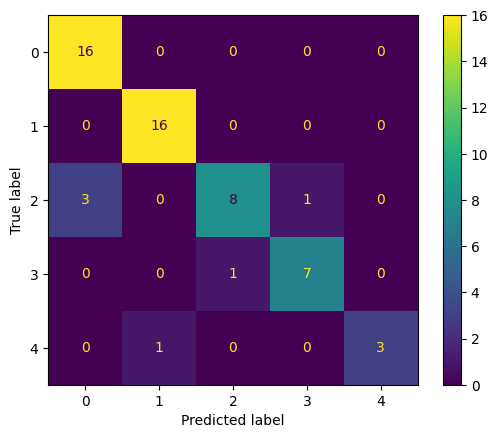

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(references, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
from PIL import Image

answers_final = dict()

with torch.no_grad():
    for f in tqdm(test_files):
        key = f.split("/")[-1].split(".")[0]

        img = Image.open(f).convert("RGB")
        transformed = transforms["test"](img).unsqueeze(0).to(device)
        answers_final[key] = loaded_model(transformed).argmax(-1).item()

answers_final

100%|██████████| 70/70 [00:06<00:00, 10.05it/s]


{'test_data10': 0,
 'test_data15': 4,
 'test_data29': 1,
 'test_data68': 3,
 'test_data41': 3,
 'test_data20': 2,
 'test_data8': 0,
 'test_data9': 3,
 'test_data17': 0,
 'test_data62': 1,
 'test_data19': 1,
 'test_data57': 3,
 'test_data34': 1,
 'test_data55': 1,
 'test_data5': 1,
 'test_data64': 4,
 'test_data12': 1,
 'test_data65': 1,
 'test_data25': 2,
 'test_data54': 3,
 'test_data33': 3,
 'test_data53': 0,
 'test_data61': 0,
 'test_data59': 2,
 'test_data51': 3,
 'test_data67': 1,
 'test_data35': 1,
 'test_data38': 2,
 'test_data28': 3,
 'test_data40': 0,
 'test_data14': 0,
 'test_data42': 0,
 'test_data2': 0,
 'test_data48': 2,
 'test_data66': 0,
 'test_data56': 0,
 'test_data70': 2,
 'test_data22': 0,
 'test_data31': 0,
 'test_data30': 0,
 'test_data36': 4,
 'test_data44': 0,
 'test_data13': 2,
 'test_data49': 0,
 'test_data23': 1,
 'test_data43': 3,
 'test_data60': 4,
 'test_data16': 0,
 'test_data47': 1,
 'test_data24': 0,
 'test_data18': 1,
 'test_data45': 3,
 'test_data52': 

In [ ]:
df = pd.read_csv("/content/Sample-submission.csv")
df

,File_name,Code
0,test_data1.csv,1.0
1,test_data2.csv,3.0
2,test_data3.csv,5.0
3,test_data4.csv,NaN
4,test_data5.csv,NaN
...,...,...
65,test_data66.csv,NaN
66,test_data67.csv,NaN
67,test_data68.csv,NaN
68,test_data69.csv,NaN


In [ ]:
df['File_name'][2].replace(".csv", "")

'test_data3'

In [ ]:
for i in range(len(df)):
    file_name = df['File_name'][i].replace(".csv", "")
    df.loc[i, 'Code'] = str(answers_final[file_name] + 1)
df

,File_name,Code
0,test_data1.csv,1
1,test_data2.csv,1
2,test_data3.csv,2
3,test_data4.csv,2
4,test_data5.csv,2
...,...,...
65,test_data66.csv,1
66,test_data67.csv,2
67,test_data68.csv,4
68,test_data69.csv,2


In [ ]:
df.to_csv('/content/MaxViT2-Base-224.csv', index=False)

##Code Version 2

In [ ]:
!pip install transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.5 MB/s eta 0:00:00


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
import os
import cv2

X_train = []
y_train = []
size = (224, 224)
directory_path = '/content/drive/MyDrive/Colab Notebooks/data/signal_train'
folder_names = [folder for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]

def importdatasets_name(name):
    input_dir = "/content/drive/MyDrive/Colab Notebooks/data/signal_train/" + name
    input_img_paths_jpg = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".jpg")
        ]
    )

    input_img_paths_png = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".png")
        ]
    )

    for i in input_img_paths_jpg:
      try:
        image = cv2.imread(i)
        image = cv2.resize(image, size)
        #image = data_augmentation(image)
        X_train.extend([image])
        y_train.extend([name])
      except:
        pass

    for i in input_img_paths_png:
      try:
        image = cv2.imread(i)
        image = cv2.resize(image, size)
        #image = data_augmentation(image)
        X_train.extend([image])
        y_train.extend([name])
      except:
        pass

for i in tqdm(folder_names):
  importdatasets_name(i)

100%|██████████| 7/7 [00:14<00:00,  2.07s/it]


In [ ]:
import os
import cv2

X_val = []
y_val = []
size = (224, 224)
directory_path = '/content/drive/MyDrive/Colab Notebooks/data/signal_val'
folder_names = [folder for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]

def importdatasets_name(name):
    input_dir = "/content/drive/MyDrive/Colab Notebooks/data/signal_val/" + name
    input_img_paths_jpg = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".jpg")
        ]
    )

    input_img_paths_png = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".png")
        ]
    )

    for i in input_img_paths_jpg:
      try:
        image = cv2.imread(i)
        image = cv2.resize(image, size)
        #image = data_augmentation(image)
        X_val.extend([image])
        y_val.extend([name])
      except:
        pass

    for i in input_img_paths_png:
      try:
        image = cv2.imread(i)
        image = cv2.resize(image, size)
        #image = data_augmentation(image)
        X_val.extend([image])
        y_val.extend([name])
      except:
        pass

for i in tqdm(folder_names):
  importdatasets_name(i)

100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


In [ ]:
class_names, y_train = np.unique(np.array(y_train), return_inverse=True)
_, y_val = np.unique(np.array(y_val), return_inverse=True)
class_names

array(['0', '1', '2', '3', '4', '5', '6'], dtype='<U1')

In [ ]:
X_train = np.stack(X_train)
X_val = np.stack(X_val)
X_train.shape, X_val.shape

((582, 224, 224, 3), (65, 224, 224, 3))

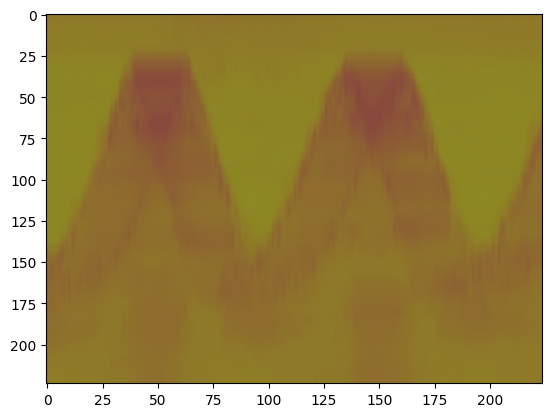

In [ ]:
plt.imshow(X_train[80], aspect="auto")

In [ ]:
import timm
import torch.nn as nn
from transformers import TrainingArguments, Trainer

class MaxxVit(nn.Module):
    def __init__(self, pretrained=True, num_classes=7):
        super(MaxxVit, self).__init__()
        self.model = timm.create_model("maxvit_large_tf_224.in1k", pretrained=pretrained, num_classes=num_classes)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, pixel_values, labels=None):
        outputs = self.model(pixel_values)
        logits = outputs
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {"logits": logits, "loss": loss}

model = MaxxVit()

model.safetensors:   0%|          | 0.00/848M [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, labels=None):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx]).permute(2, 0, 1).float()
        if self.labels is not None:
            label = torch.tensor(self.labels[idx])
            return {"pixel_values": image, "label": label}
        else:
            return {"pixel_values": image}

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

In [ ]:
from transformers import default_data_collator

training_args = TrainingArguments(
    output_dir="./maxvit_training_output",
    num_train_epochs=15,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    eval_steps=500,
    evaluation_strategy="epoch",
    weight_decay=0.01,
    logging_dir="./logs",
    learning_rate=1e-4,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
    tokenizer=None,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,1.489890


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

results = trainer.predict(val_dataset)
predicted_labels = torch.argmax(torch.tensor(results.predictions), axis=1).numpy()
accuracy = accuracy_score(y_val, predicted_labels)
f1 = f1_score(y_val, predicted_labels, average="weighted")

print(f"Validation Accuracy: {accuracy}")
print(f"Validation F1 Score: {f1}")

Validation Accuracy: 0.676923076923077
Validation F1 Score: 0.6667707172054999


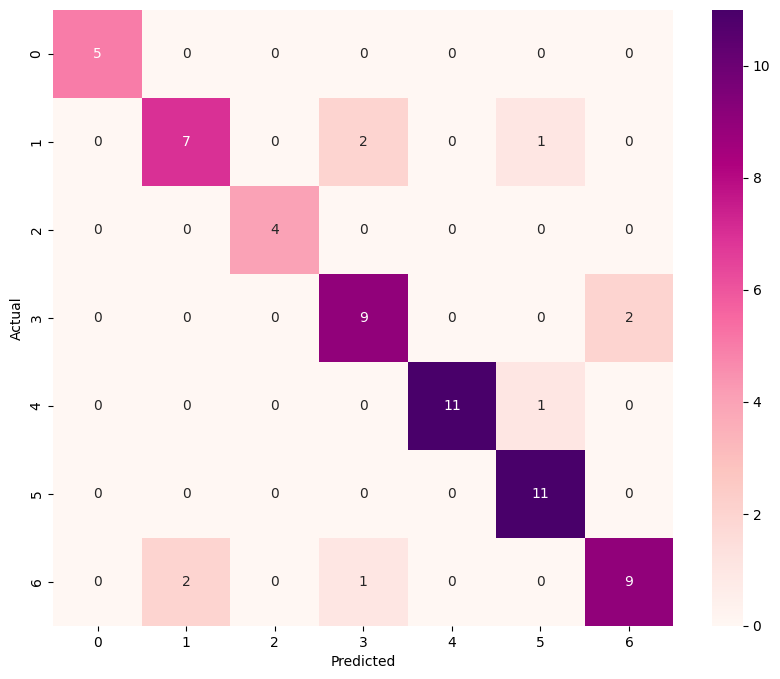

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_val, predicted_labels), annot=True, cmap='RdPu', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
input_dir = "/content/signal_test"

input_img_paths_png = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)

print("Number of samples:", len(input_img_paths_png))

Number of samples: 70


In [ ]:
X_test = []

for i in tqdm(input_img_paths_png):
  image = cv2.imread(i)
  image = cv2.resize(image, (224, 224))
  X_test.append(image)

100%|██████████| 70/70 [00:00<00:00, 86.21it/s]


In [ ]:
X_test = np.stack(X_test)
X_test.shape

(70, 224, 224, 3)

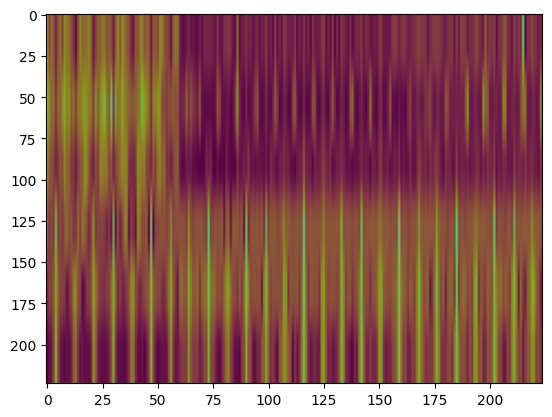

In [ ]:
plt.imshow(X_test[3], aspect="auto")

In [ ]:
class TestDataset(Dataset):
    def __init__(self, images, labels=None):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx]).permute(2, 0, 1).float()
        return {"pixel_values": torch.tensor(image)}

test_dataset = TestDataset(X_test)
model.to("cpu")
model.eval()

predicted_labels = []
with torch.no_grad():
    for sample in tqdm(test_dataset):
        pixel_values = sample["pixel_values"].unsqueeze(0)
        logits = model(pixel_values)["logits"]
        predictions = torch.argmax(logits, dim=1).item()
        predicted_labels.append(predictions)
predicted_labels = np.array(predicted_labels)

  0%|          | 0/70 [00:00<?, ?it/s]<ipython-input-71-383c13c39b9f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"pixel_values": torch.tensor(image)}
100%|██████████| 70/70 [01:12<00:00,  1.03s/it]


In [ ]:
predicted_labels

array([0, 0, 3, 1, 2, 0, 1, 3, 3, 1, 1, 2, 2, 4, 0, 1, 3, 2, 2, 1, 3, 1,
       4, 0, 0, 3, 3, 1, 1, 4, 1, 2, 1, 1, 0, 3, 0, 3, 0, 3, 2, 1, 2, 0,
       1, 1, 3, 0, 0, 1, 1, 0, 3, 2, 2, 0, 4, 0, 1, 0, 4, 1, 0, 1, 3, 1,
       2, 2, 0, 3])

In [ ]:
ans = class_names[predicted_labels]
print(len(ans[ans == '1']))
print(len(ans[ans == '2']))
print(len(ans[ans == '3']))
print(len(ans[ans == '4']))
print(len(ans[ans == '5']))

18
21
12
14
5


In [ ]:
df = pd.read_csv("/content/Sample-submission.csv")
df

,File_name,Code
0,test_data1.csv,1.0
1,test_data2.csv,3.0
2,test_data3.csv,5.0
3,test_data4.csv,NaN
4,test_data5.csv,NaN
...,...,...
65,test_data66.csv,NaN
66,test_data67.csv,NaN
67,test_data68.csv,NaN
68,test_data69.csv,NaN


In [ ]:
df['File_name'][2].replace(".csv", "")

'test_data3'

In [ ]:
input_img_paths_png[2].replace("/content/signal_test/", "").replace(".png", "")

'test_data11'

In [ ]:
for i in range(len(df)):
    file_name = df['File_name'][i].replace(".csv", "")
    for j in range(len(df)):
        img_path = input_img_paths_png[j].replace("/content/signal_test/", "").replace(".png", "")
        if file_name == img_path:
            df.loc[i, 'Code'] = ans[j]
            break
df

,File_name,Code
0,test_data1.csv,1
1,test_data2.csv,3
2,test_data3.csv,5
3,test_data4.csv,2
4,test_data5.csv,2
...,...,...
65,test_data66.csv,1
66,test_data67.csv,2
67,test_data68.csv,4
68,test_data69.csv,2


In [ ]:
df.to_csv('/content/MaxViT-Base-224.csv', index=False)